# ANN Classification Model Notebook for Group 8


## Classification Neural Network based on Income Group using PyTorch


### Load the dataset


In [1]:
import pandas as pd
import numpy as np
dataset = pd.read_csv('datasets/fies_df_for_ML.csv')

### As discussed in the data exploration notebook, only expenditure columns will be used as inputs to avoid data leakage


In [2]:
# Get all expenditure columns as features
expenditure_columns = [
    "family_size",
    "losses_from_entrepreneurial_activities",
    "expenditure_cereal_preparations",
    "expenditure_meat_preparations",
    "expenditure_fish_marine_products",
    "expenditure_dairy_eggs",
    "expenditure_oils_fats",
    "expenditure_fruits_vegetables",
    "expenditure_vegetables",
    "expenditure_sugar_jam_honey",
    "expenditure_other_food",
    "expenditure_fruit_vegetable_juices",
    "expenditure_coffee_cocoa_tea",
    "expenditure_tea",
    "expenditure_cocoa",
    "main_water_supply_second_visit",
    "expenditure_softdrinks",
    "expenditure_non_alcoholic_beverages",
    "expenditure_alcoholic_beverages",
    "expenditure_tobacco",
    "expenditure_other_vegetables",
    "expenditure_services_primary_goods",
    "expenditure_alcohol_production_services",
    "total_food_consumed_home",
    "food_consumed_outside_home",
    "household_food_expenditure",
    "expenditure_clothing_footwear",
    "expenditure_housing_water",
    "actual_house_rent",
    "imputed_house_rental_value",
    "imputed_housing_benefit_rental_value",
    "house_rent_rental_value",
    "expenditure_furnishings_household_maintenance",
    "expenditure_health",
    "expenditure_transportation",
    "expenditure_communication",
    "expenditure_recreation_culture",
    "expenditure_education",
    "expenditure_insurance",
    "expenditure_miscellaneous_goods_services",
    "expenditure_durable_furniture",
    "expenditure_special_family_occasion",
    "other_expenditure",
    "other_disbursements",
    "expenditure_accommodation_services",
    "total_non_food_expenditure",
    "total_household_expenditures",
    "total_household_disbursements",
    "urban_rural",
    'income_group', # include target variable
]

In [3]:
# Only use expenditure columns
expenditure_dataset = dataset[expenditure_columns]

### A stratify split is used to get equal representation for all income statuses for the train and test dataset. A standard 70-30 split is used


In [4]:
# Stratified split to get equal representation of all income statuses:
from sklearn.model_selection import train_test_split

# 70% for training, and 30% for test
train, test = train_test_split(
    expenditure_dataset,
    test_size=0.3,
    stratify=dataset['income_group'],
    random_state=42
)
print(f'Training Set Shape: ', train.shape)
print(f'Test Set Shape: ', test.shape)

Training Set Shape:  (114287, 50)
Test Set Shape:  (48981, 50)


In [5]:
# Split the dataset into training and testing sets
target_column = ['income_group']
X_train, y_train = train.drop(columns=target_column), train['income_group']
X_test, y_test = test.drop(columns=target_column), test['income_group']

### Scaling and encoding the data


In [6]:
# Scale all data 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
scaler = StandardScaler()

# For Training and Testing with scaling
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encoding the Target Variable
label_encoder = LabelEncoder()

# For Training and Testing with encoding
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### For the Classification Model, the group has decided to use PyTorch to implement the model.


In [7]:
# Convert to PyTorch Tensors
import torch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [8]:
from torch.utils.data import TensorDataset, DataLoader
# Define the TensorDataset and DataLoader along with a constant BATCH_SIZE
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### This cell defines the structure of the ANN architecture

Scope and Limitation:

1. The time to experiment the model architecture and the hyperparamters were limited; therefore the researchers suggest more experiments to be done since the dataset is complex and to get a more robust analysis and evaluation on the model.


In [9]:
# Defining the ANN Architecture
import torch.nn as nn

class FIESANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.output_neuron = nn.Linear(16, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.output_neuron(x)
        return x

### A custom EarlyStopping function is defined to track loss, and potentially other classification metrics with a few modifications


In [10]:
# Custom EarlyStopping function
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path=None):
        """
        Args:
            patience (int): How long to wait after last time the F1 score improved.
                            Default: 7
            verbose (bool): If True, prints a message for each F1 score improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for saving the model if it improves. If None, stores the state in memory.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_val_score = -np.inf
        self.best_model_state = None

    def __call__(self, val_score, model):
        if not np.isfinite(val_score):
            # Skip NaN or infinite values
            if self.verbose:
                print("Warning: Invalid score (NaN or Inf). Skipping update.")
            return

        if self.best_score is None:
            self.best_score = val_score
            self.save_checkpoint(val_score, model)
        elif val_score > self.best_score + self.delta: # adjust this to < when tracking a metric instead if loss
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.save_checkpoint(val_score, model)
            self.counter = 0

    def save_checkpoint(self, val_score, model):
        """Saves model when validation score improves."""
        if self.verbose:
            print(f"Tracked Validation Score improved ({self.best_val_score:.4f} --> {val_score:.4f}). Saving model...")
        if self.path:
            torch.save(model.state_dict(), self.path)
        else:
            self.best_model_state = model.state_dict()
        self.best_val_score = val_score

### K-Fold Cross-Validation is used to get a more robust evaluation of the model. The model is trained and evaluated for each fold


In [11]:
# Setting up K-Fold Validation for a more robust evaluation
from sklearn.model_selection import KFold
EPOCHS = 100
k_folds = 5
initial_lr = 0.001

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Metrics storage
fold_metrics = {
    "train_loss": [],
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "train_f1": [],
}

fold_performance = {
    "train_loss": [],
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "train_f1": [],
}

### The best metrics per fold are tracked and stored in the fold_performance dictionary, while all of the metrics per fold are stored in the fold_metrics dictionary.

### Fold metrics will be used to get the average performance for all folds, while fold_performance will be used as a basis to load the best ann_checkpoint


In [12]:
# Start K-Fold Training
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Subset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Split the data into training and validation sets
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize the model, optimizer and utility methods
    model = FIESANN(input_size=X_train.shape[1], num_classes=dataset['income_group'].nunique())
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15)
    early_stopping = EarlyStopping(patience=30, delta=0.00001, path=f'checkpoints/fies_ann_checkpoint_fold{fold+1}.pth', verbose=True)

    best_train_loss = np.inf
    best_train_accuracy = 0.0
    best_train_precision = 0.0
    best_train_recall = 0.0
    best_train_f1 = 0.0

    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        train_loss = 0
        y_train_true = []
        y_train_pred = []
        
        for batch in train_dataloader:
            inputs, labels = batch
            outputs = model(inputs)  # Outputs shape: (batch_size, num_classes)
            
            # Use CrossEntropyLoss for multi-class classification
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Get predicted class (index of the max logit)
            preds = torch.argmax(outputs, dim=1)
            
            y_train_true.extend(labels.cpu().numpy())
            y_train_pred.extend(preds.cpu().numpy())
        
        train_loss /= len(train_dataloader)
        
        # Calculate metrics (multi-class version)
        train_accuracy = accuracy_score(y_train_true, y_train_pred)
        train_precision = precision_score(y_train_true, y_train_pred, average='macro')
        train_recall = recall_score(y_train_true, y_train_pred, average='macro')
        train_f1 = f1_score(y_train_true, y_train_pred, average='macro')

        fold_metrics["train_loss"].append(np.round(train_loss, 4))
        fold_metrics["train_accuracy"].append(train_accuracy)
        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)

        print(f'Epoch [{epoch+1}/{EPOCHS}] with Learning Rate: {lr_scheduler.get_last_lr()} \nLoss: {train_loss:.4f}' +  
            f'\nTrain Accuracy: {train_accuracy:.2%} Train Precision: {train_precision:.2%}, Train Recall: {train_recall:.2%}, Train F1 Score: {train_f1:.2%}\n')
        
        lr_scheduler.step(train_loss)
        early_stopping(train_loss, model)
        if train_accuracy > best_train_accuracy:
            best_train_loss = train_loss
            best_train_accuracy = train_accuracy
            best_train_precision = train_precision
            best_train_recall = train_recall
            best_train_f1 = train_f1
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    fold_performance["train_loss"].append(np.round(best_train_loss, 4))
    fold_performance["train_accuracy"].append(best_train_accuracy)
    fold_performance["train_precision"].append(best_train_precision)
    fold_performance["train_recall"].append(best_train_recall)
    fold_performance["train_f1"].append(best_train_f1)
    print(f"\nFold {fold + 1} Performance:\n")
    print(f"Best Train Loss: {best_train_loss:.4f}")
    print(f"Best Train Accuracy: {best_train_accuracy:.2%}")
    print(f"Best Train Precision: {best_train_precision:.2%}")
    print(f"Best Train Recall: {best_train_recall:.2%}")
    print(f"Best Train F1 Score: {best_train_f1:.2%}")


    

Fold 1/5
Epoch [1/100] with Learning Rate: [0.001] 
Loss: 0.6214
Train Accuracy: 74.49% Train Precision: 62.70%, Train Recall: 54.26%, Train F1 Score: 57.19%

Tracked Validation Score improved (-inf --> 0.6214). Saving model...
Epoch [2/100] with Learning Rate: [0.001] 
Loss: 0.5595
Train Accuracy: 76.70% Train Precision: 67.05%, Train Recall: 60.86%, Train F1 Score: 63.26%

Tracked Validation Score improved (0.6214 --> 0.5595). Saving model...
Epoch [3/100] with Learning Rate: [0.001] 
Loss: 0.5541
Train Accuracy: 76.90% Train Precision: 67.59%, Train Recall: 61.46%, Train F1 Score: 63.96%

Tracked Validation Score improved (0.5595 --> 0.5541). Saving model...
Epoch [4/100] with Learning Rate: [0.001] 
Loss: 0.5498
Train Accuracy: 77.14% Train Precision: 69.32%, Train Recall: 63.43%, Train F1 Score: 65.81%

Tracked Validation Score improved (0.5541 --> 0.5498). Saving model...
Epoch [5/100] with Learning Rate: [0.001] 
Loss: 0.5452
Train Accuracy: 77.32% Train Precision: 69.75%, Train

### Metrics Aggregation


In [13]:
# Aggregate metrics across all folds
avg_train_loss = np.mean(fold_metrics["train_loss"])
avg_train_accuracy = np.mean(fold_metrics["train_accuracy"])
avg_train_precision = np.mean(fold_metrics["train_precision"])
avg_train_recall = np.mean(fold_metrics["train_recall"])
avg_train_f1 = np.mean(fold_metrics["train_f1"])

print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_accuracy:.2%}")
print(f"Average Train Precision: {avg_train_precision:.2%}")
print(f"Average Train Recall: {avg_train_recall:.2%}")
print(f"Average Train F1 Score: {avg_train_f1:.2%}")

# Print the Best performance across all folds
best_fold = np.argmin(fold_performance["train_loss"])
best_train_loss = fold_performance["train_loss"][best_fold]
best_train_accuracy = fold_performance["train_accuracy"][best_fold]
best_train_precision = fold_performance["train_precision"][best_fold]
best_train_recall = fold_performance["train_recall"][best_fold]
best_train_f1 = fold_performance["train_f1"][best_fold]

print(f"Best Fold: {best_fold + 1}")
print(f"Best Train Loss: {best_train_loss:.4f}")
print(f"Best Train Accuracy: {best_train_accuracy:.2%}")
print(f"Best Train Precision: {best_train_precision:.2%}")
print(f"Best Train Recall: {best_train_recall:.2%}")
print(f"Best Train F1 Score: {best_train_f1:.2%}")

Average Train Loss: 0.5117
Average Train Accuracy: 78.52%
Average Train Precision: 73.59%
Average Train Recall: 66.71%
Average Train F1 Score: 69.70%
Best Fold: 4
Best Train Loss: 0.4922
Best Train Accuracy: 79.40%
Best Train Precision: 75.17%
Best Train Recall: 68.80%
Best Train F1 Score: 71.65%


### Model Evaluation

The best performing model from fold_performance was used for evaluation


In [14]:
# Evaluate the model on the test set
model.eval()
test_loss = 0
y_test_true = []
y_test_pred = []
model.load_state_dict(torch.load(f'checkpoints/fies_ann_checkpoint_fold{best_fold+1}.pth'))
print(f"Loading model from checkpoint: checkpoints/fies_ann_checkpoint_fold{best_fold+1}.pth")
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predicted class (index of the max logit)
        preds = torch.argmax(outputs, dim=1)

        y_test_true.extend(labels.cpu().numpy())
        y_test_pred.extend(preds.cpu().numpy())

test_loss /= len(test_dataloader)
test_accuracy = accuracy_score(y_test_true, y_test_pred)
test_precision = precision_score(y_test_true, y_test_pred, average='macro')
test_recall = recall_score(y_test_true, y_test_pred, average='macro')
test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.2%}')
print(f'Test Precision: {test_precision:.2%}')
print(f'Test Recall: {test_recall:.2%}')
print(f'Test F1 Score: {test_f1:.2%}')

Loading model from checkpoint: checkpoints/fies_ann_checkpoint_fold4.pth


/var/folders/mp/c7pgmq8j0472f05vnx5h16000000gn/T/ipykernel_80734/3520914535.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'checkpoint

Test Loss: 0.5873
Test Accuracy: 76.19%
Test Precision: 69.07%
Test Recall: 61.32%
Test F1 Score: 64.37%


### Visualizations


#### Confusion Matrix

A confusion matrix is a good visualization of the model's performance


In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred)
cm_df = pd.DataFrame(cm, index=dataset['income_group'].unique(), columns=dataset['income_group'].unique())

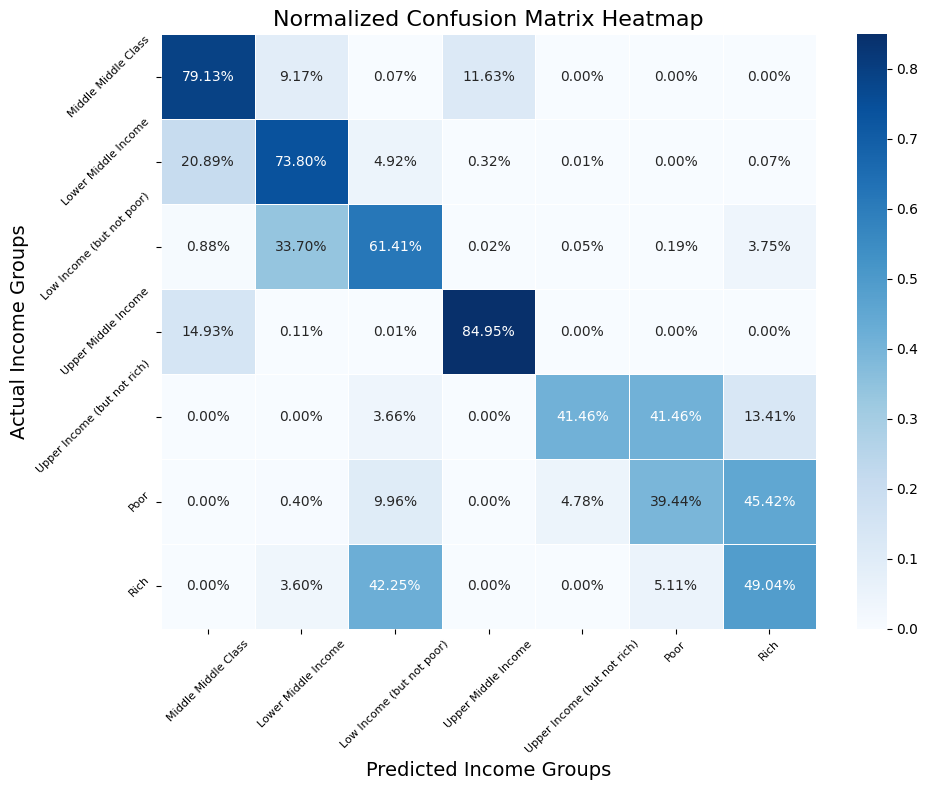

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
income_group_labels = dataset['income_group'].unique()

# Normalize the confusion matrix by dividing by the row sums (convert to percentage)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]  

cm_normalized_df = pd.DataFrame(cm_normalized, index=income_group_labels, columns=income_group_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized_df, annot=True, fmt=".2%", cmap="Blues", linewidths=0.5, cbar=True)

plt.title("Normalized Confusion Matrix Heatmap", fontsize=16)
plt.xlabel("Predicted Income Groups", fontsize=14)
plt.ylabel("Actual Income Groups", fontsize=14)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(rotation=45, fontsize=8)

plt.tight_layout()
plt.show()


<b>DISCLAIMER</b>: Due to the limitations in terms of experimentation, all insights made are <b>strictly</b> based on the findings of the metrics in this notebook

From the heatmap provided above, we can discern the model's performance for each of the 7 income groups.

1. Middle Middle Class - The model performed well in this group, suggesting that middle middle class people relatively spend inline with their incomes
   
2. Lower Middle Income - Model also performed well, suggesting the same observation with this income group. Addtionally, the model seemed to mistakenly categorize lower middle income families to middle middle class more, suggesting some similar habits in terms of spending
   
3. Low Income (but not poor) - The model performed good, but the model seemed to mistakenly categorize these families to lower middle income, which suggests that lower middle income familiy and low income families are very similar in terms of spending patterns.
   
4. Upper Middle Income - The model performed best for this group, with the only exception being that the model mistakenly categorizes these as middle middle class families, which would be understandable since it is viable that upper middle income and middle middle income families have similar spending habits.
   
5. Upper Income (but not rich) - Starting from this group, the model seemed to struggle in classification. Most interestingly, the model seemed to have a lot of mistakes with classifying this group as poor, which can be interpreted as the spending patterns of upper income and poor families do not differ as much, which is not to be expected.
   
6. Poor - Similary to Upper Income, the model struggled but this time, the model classifies this group as rich. The poor income group and the rich income group have the largest disparity in terms of income per month, which makes this an interesting insight on the spending patterns of these two groups.
   
7. Rich - The model also struggled with this group, often mistaking this group with the low income (but not poor). Similar with previous observations, this could highlight some similar spending habits that may have been picked up by the model.


Following the performance of the model, the following insights are made specifically to each of the income groups
Actionable Insights:

1. Middle Middle Class
   
   a. Since the spending aligns with the income, some financial stability practices like balanced budgeting and financial literacy practices may be essential to potentially help their financial situation and maybe rise up an income group.

   b. Some research on investment opportunities can open up another source of income, although this is not the priority as people in this income group may not likely have the extra financial funds to supply this venture, especially with large family sizes.

2. Lower Middle Income
   
   a. Planning in terms of saving and investment can gradually elevate them into Middle Middle class, since their spending patterns closely resemble the Midlle Middle Class

   b. Financial Products like low-interest savings accounts or beginner investment plans are good ways to maybe have financial stability

3. Low Income (but not poor)
   
   a. Since this is where majority of the Filipino lie, it is important for this income group to learn basic financial literacy like the importance of emergency funds, debt management, efficient spending, and budgeting.

   b. For the government, it would be beneficial to tailor-fit financial support services to this group, reducing reliance on high-interest loans.

4. Upper Middle Income
   
   a. Diversify their financial portfolio, as they have a higher chance of having financial freedom in this group.

5. Upper Income (but not rich)
   
   a. For future researches, an investigation on the frugal habits found by the model can be a good starting point as things like cultural values, disciplined spending, and many more can be the reason for this anomaly.

6. Poor
   
   a. For future researches, the spending behavior of this groups mimics the rich according to the findings of the model. This could be an interesting insight on the factors that may be responsible for this behavior.

   b. Financial literacy programs are a must for education on budgeting and unnecessary spending and debt.

   c. Local LGUs and the government can collaborate with the community to improve access to relief goods and free services to help this group, as the high spending pattern can be attributed to healthcare spending or livelihood spending.

7. Rich
   
   a. For future researches, the spending behavior of this groups mimics the poor according to the findings of the model. A deep-dive into the reasons behind this behavior like the rich's focus on priorizing savings and investments can be a good starting point.

   b. For this group, philanthropy programs can serve to help their community, since their spending habits do not really correlate according to the model.

Better if strenghten yung livestock industry natin because additional tariff nagpapamahal ng karne, which in this case less makukuha nila per peso

identify yung location ng fresh marine products pR mastreamline yung logistical approach 
para local and high quality yungm ga ginagamit na fishes sa places like ncr area

total spending on education per region then lowest region igroup by province naman yung lowest spending, tapos rank then action

visualization ng below poveryt line per region. recommendation to each region's lgus to possibly create 
job opportunities for them and/or training for blue collared jobs

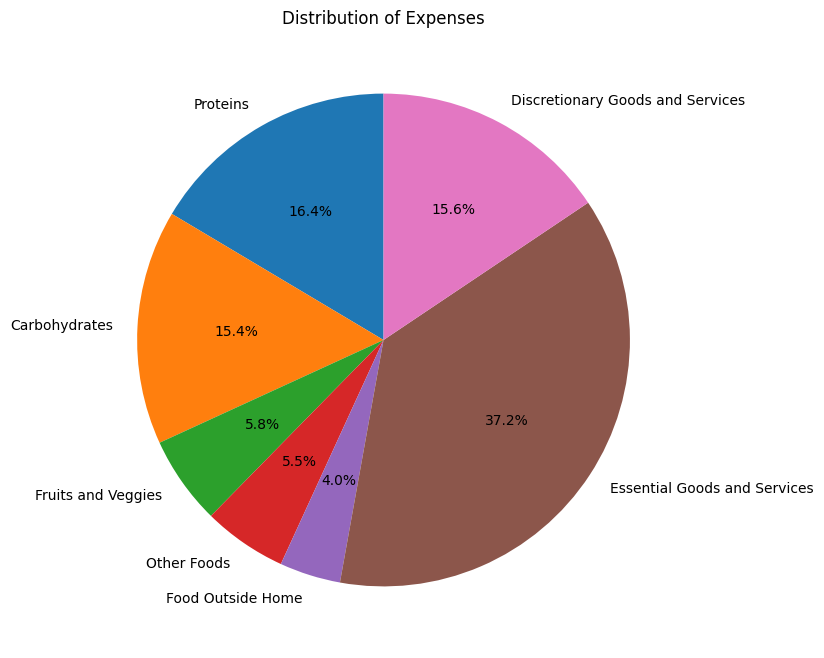

In [19]:
import matplotlib.pyplot as plt

columns_ratio = ['expenditure_protein_share', 'expenditure_carbohydrates_share', 'expenditure_fruits_and_veggies_share',
                'expenditure_other_foods_share', 'expenditure_food_outside_home_share', 'expenditure_essential_goods_and_services',
                'expenditure_discretionary_goods_and_services']

mean_values = dataset[columns_ratio].mean()

columns_label = ['Proteins', 'Carbohydrates', 'Fruits and Veggies', 'Other Foods', 'Food Outside Home', 'Essential Goods and Services', 'Discretionary Goods and Services']
plt.figure(figsize=(8, 8))
plt.pie(
    mean_values, 
    labels=columns_label, 
    autopct='%1.1f%%', 
    startangle=90,
)

plt.title('Distribution of Expenses')
plt.show()

This pie chart represent the mean distribution of the different expenses of Filipino households. With only a little under 50% of the total expenses spent on food. This significant portion highlights the importance of agricultural produce/products. And as we know, the Philippines is an agricultural country. However, the Philippines still heavily rely on the importation of agricultural products. The bar graphs taken from the PSA shows that 14.8% of the total imports is from agricultural imports. Furthermore, the Philippines was the top rice importer in 2023 (ASEAN Food Security Information System (AFSIS), 2024) which was more than double of the second biggest ASEAN importer, Indonesia. Additionally, the inventory of the National Meat Inspection Services (NMIS) showed imports making 98% of the 73,869.34 of frozen pork surveyed in the market.

This issue won't be resolved anytime soon given that on the June 30, 2022, President Bong Bong Marcos appointed himself as the Secretary of Agriculture. From July 2022, to May 2023, the average inflation rate for food was at 9% which, as compared to the same period the year prior, the inflation rate was only 3.4% (Famatigan, 2023). Furthermore, on April 21, 2024, PBBM issued Administrative Order No. 20 which removed non-tariff barriers(Nontariff barriers include quotas, import licensing systems, regulations and red tape that restrict or delay the entry of imports) on imported agricultural products. AGAP party-list representative Nicanor Briones remarked that "Kapag binasa mo (yung AO), parang drinaft ng importer. Nakonsulta ba ang ating mga farmers bago inilabas ang AO" Furthermore, Current Agriculture Secretary Francisco Tiu Laurel Jr. said that his team was not consulted when the AO No. 20 was crafted and said that the AO is only a "band-aid solution to a temporary problem,... at marami kasing ibang problema" (Lalu, 2024).

First and Foremost, we recommend coordinating with the experts when it comes to issuing policies that would greatly affect the agriculture sector, or any sector for that matter. Futhermore, we also recommend consulting with the supposed affected parties: farmers, fishermen, etc., to gather their opinion and make informed decisions on policy making. We also recommend strengthening our import policies to ensure that it caters to the local market and protect our farmers. As well as enhancing agricultural finance backing, to help small farmers have more access to loans to help promote increase productivity. Lastly, we also recommend improving logistical infrastructure in order to boost trasportation efficiency, which also helps reudcing losses for perishable goods.

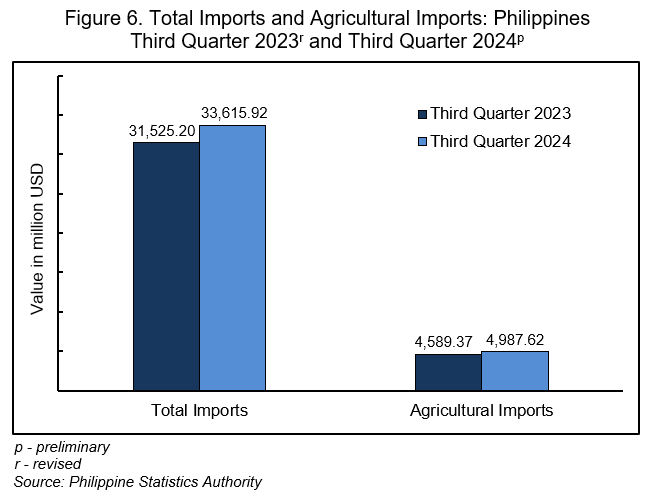 

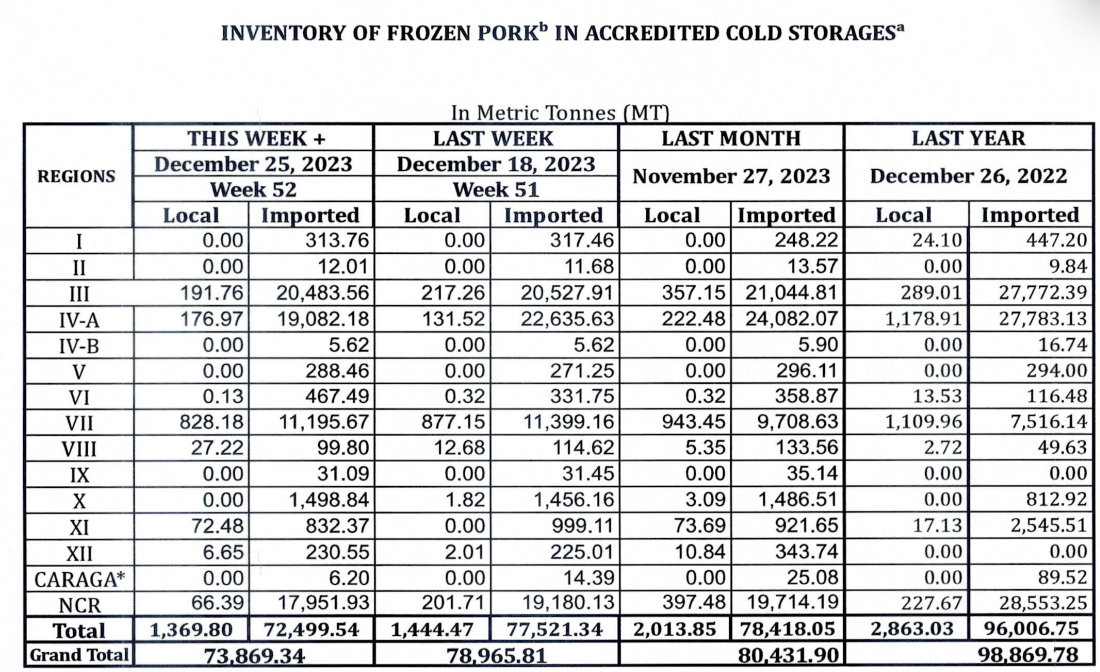

In [56]:
region_mapping = {
    1: 'I',            # Region I - Ilocos
    2: 'II',           # Region II - Cagayan Valley
    3: 'III',          # Region III - Central Luzon
    4: 'IV-A',         # Region IV-A - CALABARZON
    5: 'V',            # Region V - Bicol
    6: 'VI',           # Region VI - Western Visayas
    7: 'VII',          # Region VII - Central Visayas
    8: 'VIII',         # Region VIII - Eastern Visayas
    9: 'IX',           # Region IX - Zamboanga Peninsula
    10: 'X',           # Region X - Northern Mindanao
    11: 'XI',          # Region XI - Davao
    12: 'XII',         # Region XII - SOCCSKSARGEN
    13: 'NCR',         # National Capital Region
    14: 'CAR',         # Cordillera Administrative Region
    15: 'BARMM',        # Bangsamoro Autonomous Region in Muslim Mindanao
    16: 'XIII',        # Region XIII - Caraga
    17: 'IV-B',         # Region IV-B - MIMAROPA
    18: 'XVIII'        # Region XVIII - Negros Island Region
}

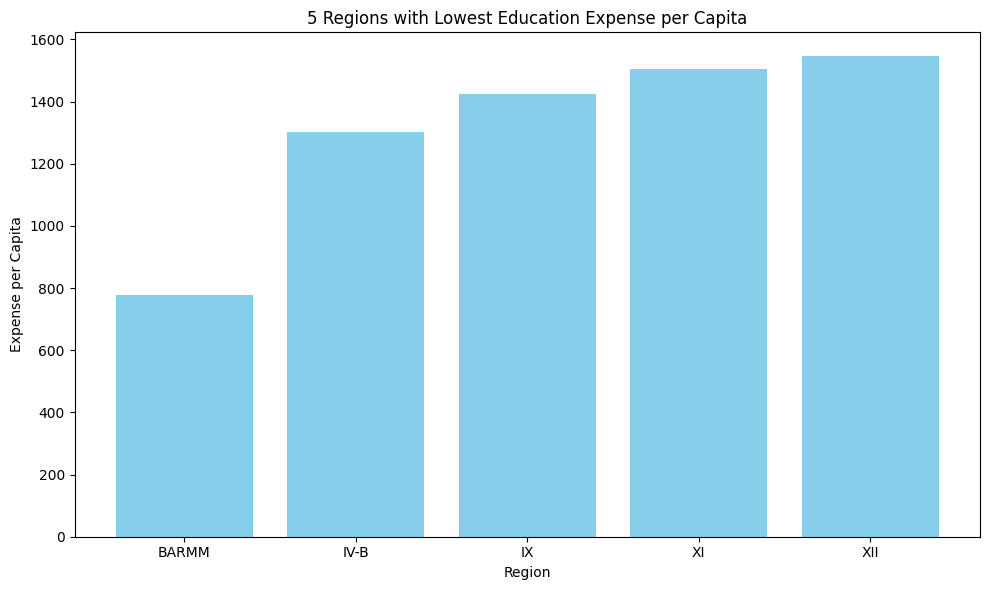

In [57]:
grouped = dataset.groupby('region').agg(
    total_education_expense=('expenditure_education', 'sum'),
    total_family_size=('family_size', 'sum')
).reset_index()

grouped['expense_per_capita'] = grouped['total_education_expense'] / grouped['total_family_size']

lowest_5 = grouped.nsmallest(5, 'expense_per_capita')
lowest_5['region_name'] = lowest_5['region'].map(region_mapping)
lowest_5['region_name'] = lowest_5['region'].apply(lambda x: region_mapping.get(x, x))

plt.figure(figsize=(10,6))
plt.bar(lowest_5['region_name'], lowest_5['expense_per_capita'], color='skyblue')
plt.xlabel('Region')
plt.ylabel('Expense per Capita')
plt.title('5 Regions with Lowest Education Expense per Capita')

plt.tight_layout()
plt.show()

As observed from the bar graph, BARMM has the lowest expenses in education per Capita. On a senate hearing back in February 2023, Senator Gatchalian that low enrollment rates have been a persistent issue in the region, stating that only 36% of minors aged 12 to 15 enrolled in junior high school and 10% of minors aged 16 to 17 enrolled in senior high school. He also mentioned that nonattendance in schools was mostly due to high cost of education, accessibility problems and lack of personal interest (Tan, 2023). This further emphasizes the big difference of the education expense per capita from BARMM to the next lowest region. Futhermore, a literacy rate table below shows the giant gap of the literacy rates from different regions in comparison to BARMM.

With the given circumstance, we recommend that the BARMM region allot a bigger portion of their budget to education to build and improve schools as well as improve existing facilities. However, the local government are already actively fixing the issue with their education. For 2024, Education got the biggest share of the BARMM budget which is a 15.36% from 2023's budget with a budget of P30.2 billion.

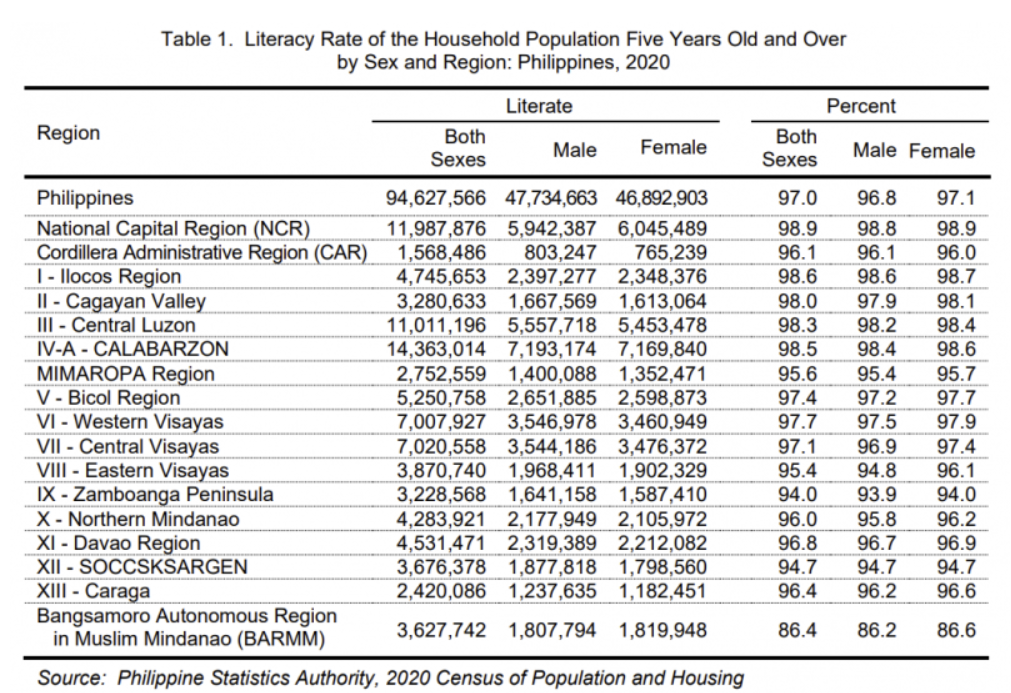

In [55]:
print(lowest_5)

    region  total_education_expense  total_family_size  expense_per_capita  \
14      15                 38226728            49230.5          776.484659   
16      17                 46991624            36080.0         1302.428603   
8        9                 41817544            29349.0         1424.837098   
10      11                 55749851            37061.0         1504.272713   
11      12                 44901586            29056.0         1545.346434   

   region_name  
14        ARMM  
16        IV-B  
8           IX  
10          XI  
11         XII  


### Summary of Performance

A table showcasing the performance of the model for train and test sets


In [17]:
# Summary of the model
from IPython.display import display, HTML

html_table = f"""
<table border="1" style="border-collapse: collapse; width: 100%;">
    <thead>
        <tr>
            <th>Train Loss</th>
            <th>Train Accuracy</th>
            <th>Train Precision</th>
            <th>Train Recall</th>
            <th>Train F1 Score</th>
            <th>Test Loss</th>
            <th>Test Accuracy</th>
            <th>Test Precision</th>
            <th>Test Recall</th>
            <th>Test F1 Score</th>
        </tr>
    </thead>

    <tbody>
        <tr>
            <td>{best_train_loss:.4f}</td>
            <td>{best_train_accuracy:.2%}</td>
            <td>{best_train_precision:.2%}</td>
            <td>{best_train_recall:.2%}</td>
            <td>{best_train_f1:.2%}</td>
            <td>{test_loss:.4f}</td>
            <td>{test_accuracy:.2%}</td>
            <td>{test_precision:.2%}</td>
            <td>{test_recall:.2%}</td>
            <td>{test_f1:.2%}</td>
        </tr>
    </tbody>
</table>
"""

display(HTML(html_table))

Train Loss,Train Accuracy,Train Precision,Train Recall,Train F1 Score,Test Loss,Test Accuracy,Test Precision,Test Recall,Test F1 Score
0.4922,79.40%,75.17%,68.80%,71.65%,0.5873,76.19%,69.07%,61.32%,64.37%
